In [726]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image
import skfuzzy as fuzz
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
from scipy.spatial.distance import cdist
import scipy.stats
import copy
import math
from scipy.integrate import quad

### Question 1  
**Write a program to implement a region segmentation algorithm using the fuzzy c-means algorithm on normalized 'RGBxy' data of an image. Merge stray (isolated) pixels (or very-smallregions) to their surrounding regions. [3 marks]**


In [2]:
img = cv2.imread("house21.jpg")
img = Image.open("house21.jpg")

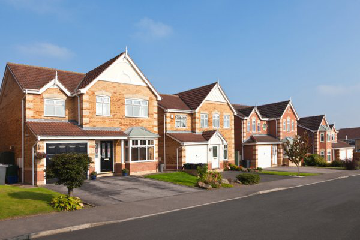

In [3]:
width, height = img.size 
newsize = (int(width*0.6), int(height*0.6))
img = img.resize(newsize)
display(img)

In [4]:
img = np.array(img)
img_data = np.zeros((img.shape[0], img.shape[1], 5))
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        img_data[i,j,0:3] = img[i,j]/255
        img_data[i,j,3] = i/img.shape[0]
        img_data[i,j,4] =  j/img.shape[1]
img_data = img_data.reshape(((img.shape[0]*img.shape[1], 5))).T
print(img_data.shape)

(5, 86400)


In [5]:
fcm = fuzz.cluster.cmeans(img_data, 25, 2, error=0.05, maxiter=1000, init=None)

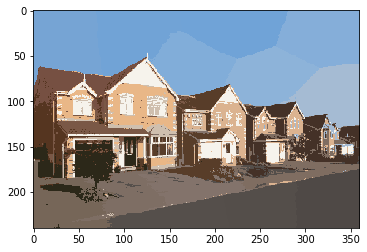

In [6]:
cluster_centers = fcm[0]
prob_matrix = fcm[1]
pred_matrix = np.argmax(prob_matrix, axis = 0)
pred_matrix = cluster_centers[pred_matrix]
clustered_image = pred_matrix[:,0:3]
clustered_image = clustered_image.reshape(((img.shape[0],img.shape[1], 3)))*255
clustered_image = clustered_image.astype(int)
plt.imshow(clustered_image)

### Question 2
**Write a program to obtain the spatial and contrast cues using SLIC superpixels of an image instead of pixels. [3 marks]**

(470, 870, 3)


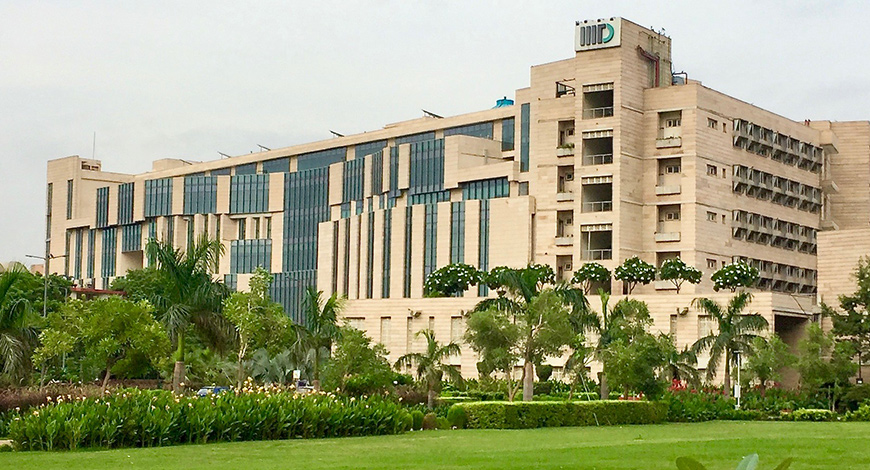

In [930]:
img_path = '1558014721_E7jyWs_iiit_d.jpg'
image  = cv2.imread(img_path)
# plt.imshow(image)
print(image.shape)
display(Image.open(img_path))

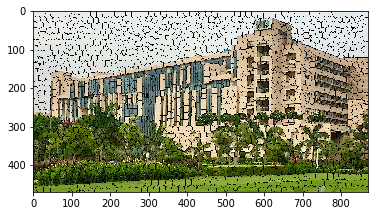

In [931]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#Initialize the slic item, the average size of super pixels is 20 (default is 10), and the smoothing factor is 20
slic = cv2.ximgproc.createSuperpixelSLIC(img,region_size=15,ruler = 20.0) 
slic.iterate(40)     #Number of iterations, the greater the better
mask_slic = slic.getLabelContourMask() #Get Mask, Super pixel edge Mask==1
label_slic = slic.getLabels()        #Get superpixel tags
number_slic = slic.getNumberOfSuperpixels()  #Get the number of super pixels
mask_inv_slic = cv2.bitwise_not(mask_slic)  
img_slic = cv2.bitwise_and(img,img,mask =  mask_inv_slic) #Draw the superpixel boundary on the original image
plt.imshow(img_slic)


In [932]:
label_slic

array([[1322, 1322, 1322, ...,   57,   57,   57],
       [1322, 1322, 1322, ...,   57,   57,   57],
       [1322, 1322, 1322, ...,   57,   57,   57],
       ...,
       [1740, 1740, 1740, ..., 1797, 1797, 1797],
       [1740, 1740, 1740, ..., 1797, 1797, 1797],
       [1740, 1740, 1740, ..., 1797, 1797, 1797]], dtype=int32)

In [933]:
def get_super_image(image, segments):
    
    m,n = segments.shape
    
    dict_ = {}
    centers = {}

    for i in range(m):
        for j in range(n):
            if(segments[i,j] not in dict_):
                dict_[segments[i,j]] = []
                centers[segments[i,j]] = []
                dict_[segments[i,j]].append(image[i,j])
                centers[segments[i,j]].append(np.array([i,j]))
            else :
                dict_[segments[i,j]].append(image[i,j])
                centers[segments[i,j]].append(np.array([i,j]))
    for key in list(dict_.keys()):
        dict_[key] = np.mean(np.array(dict_[key]), 0).astype(int)
        centers[key] = np.mean(np.array(centers[key]), 0).astype(int)
            
    slic_image = np.zeros((image.shape[0],image.shape[1],3))
    
    for i in range(m):
        for j in range(n):
            slic_image[i,j] =  dict_[segments[i,j]]
    slic_image = slic_image.astype(int)
    
#     print(slic_image)
    plt.imshow(slic_image)
    plt.title("SLIC Image")
    
    return slic_image, dict_, centers

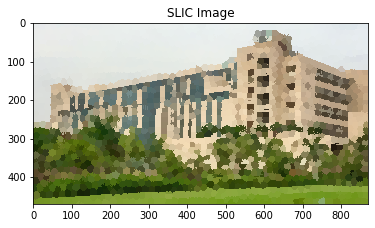

In [934]:
slic_image, dict_pixels, dict_centers = get_super_image(img,label_slic)

![title](contrast_cue_formula.PNG)
![title](spatial_cue_formula.PNG)



In [990]:
def contrast_spatial_cue(slic_image, dict_pixels, label_slic, dict_centers):
    m,n = label_slic.shape
    
    data = np.zeros((len(list(dict_pixels.keys())), 3))
    l = sorted(list(dict_pixels.keys()))
    for i in range(len(l)):
        data[i] = dict_pixels[l[i]]
    
    data = np.float32(data)/255
    
    s_scores = []
    k = 5
    s_max = 0
    for k_i in tqdm(range(16,81), position = 0, desc = "Finding best k"):
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, 0.2)
        _, labels, (centers) = cv2.kmeans(data, k_i, None, criteria, 200, cv2.KMEANS_RANDOM_CENTERS )
        ss = silhouette_score(data, np.squeeze(labels))
        s_scores.append(ss)
        if(ss > s_max):
            s_max = ss
            k = k_i
        
    plt.plot([i for i in range(16,81)], s_scores)
    plt.xlabel("Value of k")
    plt.ylabel("silhouette score")
    plt.show()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, 0.02)
    _, labels, (centers) = cv2.kmeans(data, k, None, criteria, 200, cv2.KMEANS_RANDOM_CENTERS )
    pred_matrix = np.squeeze(labels)
    cluster_dist = cdist(centers,centers, 'euclidean')
    clustered_img = pred_matrix[label_slic]

    n_i = {}
    for i in np.unique(clustered_img):
        n_i[i] = np.count_nonzero(clustered_img == i)
    print("\033[1mNumber of Image Pixels per cluster : \033[0m",n_i)
    
    contrast_cues = {}
    for i in range(k):
        val = 0
        for j in range(k):
            if(i!=j):
                val+=(n_i[j]/(clustered_img.shape[0]*clustered_img.shape[1]))*cluster_dist[i,j]
        contrast_cues[i] = val
    print("\033[1mContrast Cues : \033[0m",contrast_cues)
    
    
    center_data = np.zeros((len(list(dict_centers.keys())), 2))
    l = sorted(list(dict_centers.keys()))
    for i in range(len(l)):
        a,b = dict_centers[l[i]]
        center_data[i,0] = a
        center_data[i,1] = b
    slic_image_center = dict_centers[label_slic[m//2,n//2]].reshape((1,2))
    slic_image_center[0,0] = slic_image_center[0,0]
    slic_image_center[0,1] = slic_image_center[0,1]
    slic_center_dist = cdist(center_data,slic_image_center,'euclidean')
    slic_center_dist_var = np.std(slic_center_dist)
    
    spatail_cues = {}
    for c in range(k):
        val = 0
        for i in range(len(slic_center_dist)):
            if(pred_matrix[i] == c):
                val+=scipy.stats.norm(0, slic_center_dist_var).pdf(slic_center_dist[i,0])
        val = val/np.count_nonzero(pred_matrix == c)
        spatail_cues[c] = val
    
                
    print("\033[1mSpatial Cues : \033[0m",spatail_cues) 
    
    final_image = np.zeros((m,n))
    for i in range(m):
        for j in range(n):
            idx = clustered_img[i,j]
            val = spatail_cues[idx]*contrast_cues[idx]
            
            final_image[i,j] = val
    
    plt.imshow(final_image, cmap = 'gray')
    plt.title("Contrast and Spatial Cues of SLIC Image")
    return contrast_cues, spatail_cues,clustered_img, final_image
      
    
    

Finding best k: 100%|██████████████████████████████████████████████████████████████████| 65/65 [00:33<00:00,  1.96it/s]


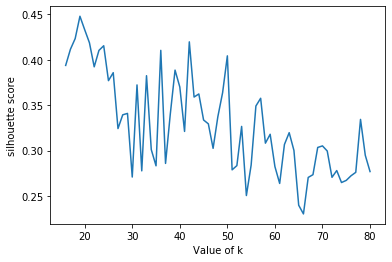

Number of Image Pixels per cluster :  {0: 20092, 1: 24172, 2: 19836, 3: 32279, 4: 3579, 5: 10369, 6: 11229, 7: 5823, 8: 10521, 9: 82053, 10: 14301, 11: 27054, 12: 17321, 13: 22287, 14: 17273, 15: 36948, 16: 7398, 17: 32464, 18: 13901}
Contrast Cues :  {0: 0.5976074554196149, 1: 0.44226449672215196, 2: 0.545672317765346, 3: 0.7210291187493674, 4: 0.49474818400973475, 5: 0.5326613353665166, 6: 0.49438628076562563, 7: 0.46747236095561684, 8: 0.47096885191185545, 9: 0.6152525032560442, 10: 0.5215852599703505, 11: 0.6207468577597676, 12: 0.4378886330716071, 13: 0.5738224133699439, 14: 0.48856019272879353, 15: 0.513461178430771, 16: 0.4501837034459434, 17: 0.4635234520912, 18: 0.529309473573988}
Spatial Cues :  {0: 0.0005151190726270642, 1: 0.00042845255275692504, 2: 0.0005378602268331492, 3: 0.00035810385410420617, 4: 0.0014097708847042127, 5: 0.0005575908364639926, 6: 0.000539935982157625, 7: 0.0008048505688618627, 8: 0.0015246780954253066, 9: 0.00038823041352419204, 10: 0.0018515908955275

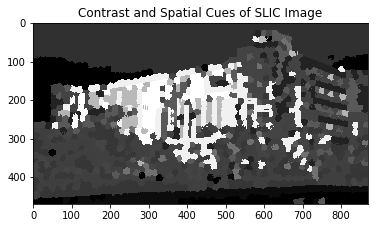

In [991]:
contrast_cues, spatail_cues,clustered_img, final_image = contrast_spatial_cue(slic_image, dict_pixels, label_slic, dict_centers)

### Question 3 
**Implement the separation measure discussed in Sec III.B.1 of the following paper to obtain 
quality scores for the two cues obtained in Q2. Use these quality scores as weights while 
performing the weighted sum of the two cues for getting the final saliency cue. [4 marks]**


In [992]:
def otsu(img):

    min_cost = float('inf')
    threshold = 0

    for i in range(1,256):
        v0 = np.var(img[img < i], ddof = 1)
        w0 = len(img[img < i])
        v1 = np.var(img[img >= i], ddof = 1)
        w1 = len(img[img >= i])

        cost = w0*v0 + w1*v1
        if(cost < min_cost):
            min_cost = cost
            threshold = i

    return threshold

In [1003]:
def select_foreground(img):
    m,n = img.shape

    m0 = int(0.15*m)
    n0 = int(0.15*n)
    c0 = 0
    c1 = 0
    for i in range(m//2 - m0, m//2 + m0):
        for j in range(n//2 - n0, n//2 + n0):
            if(img[i,j] == 0):
                c0 = c0 + 1
            else:
                c1 = c1 + 1
    if(c0 > c1):
        return 0
    else :
        return 1

Finding best k: 100%|██████████████████████████████████████████████████████████████████| 65/65 [00:28<00:00,  2.32it/s]


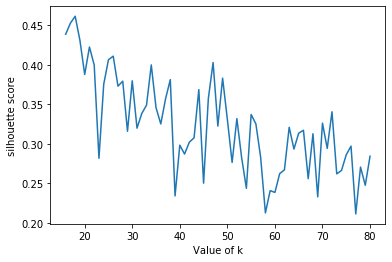

Number of Image Pixels per cluster :  {0: 19357, 1: 11517, 2: 7108, 3: 35311, 4: 7695, 5: 9092, 6: 16353, 7: 12198, 8: 28958, 9: 9179, 10: 21373, 11: 24718, 12: 32597, 13: 25628, 14: 10186, 15: 21988, 16: 103649, 17: 11993}
Contrast Cues :  {0: 0.5186066874268556, 1: 0.48526309427977643, 2: 0.45706598944864013, 3: 0.5162378088263035, 4: 0.8057117730745857, 5: 0.4787376919872852, 6: 0.5170472531476965, 7: 0.43880431651788904, 8: 0.6613249113125463, 9: 0.44418062690476207, 10: 0.5130102604135255, 11: 0.5831140855580287, 12: 0.46648374349068994, 13: 0.44276696294386686, 14: 0.4725504116108192, 15: 0.5810209252101645, 16: 0.6015164949198417, 17: 0.7164677048930094}
Spatial Cues :  {0: 0.00015090718649393627, 1: 0.00023586343840746116, 2: 0.0008341593657895033, 3: 0.0018254379005244394, 4: 0.00019281970666164814, 5: 0.0006692708909846779, 6: 0.0018994700441757537, 7: 0.0006157647397674816, 8: 0.0004327964242820977, 9: 0.0012586974086499462, 10: 0.0005536169631522505, 11: 0.00049254683340603

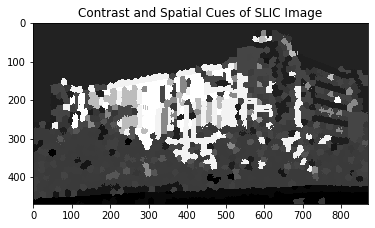

In [993]:
contrast_cues, spatail_cues,clustered_img, final_image = contrast_spatial_cue(slic_image, dict_pixels, label_slic, dict_centers)

In [994]:
s_max = max(list(spatail_cues.values()))
for key in list(spatail_cues.keys()):
    spatail_cues[key] = spatail_cues[key]/s_max

c_max = max(list(contrast_cues.values()))
for key in list(contrast_cues.keys()):
    contrast_cues[key] = contrast_cues[key]/c_max


Text(0.5, 1.0, 'Contrast Cue Image')

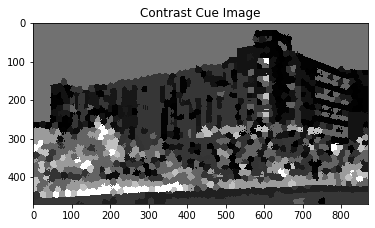

In [995]:
m,n = clustered_img.shape
contrast_cue_image = np.zeros((m,n))
for i in range(m):
    for j in range(n):
        contrast_cue_image[i,j] = contrast_cues[clustered_img[i,j]]
plt.imshow(contrast_cue_image, cmap = 'gray')
plt.title("Contrast Cue Image")
        

Text(0.5, 1.0, 'Spatial Cue Image')

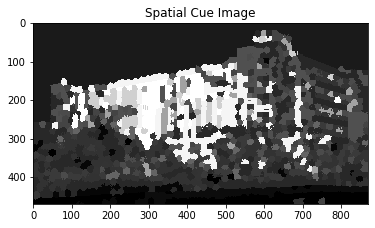

In [996]:
m,n = clustered_img.shape
spatial_cue_image = np.zeros((m,n))
for i in range(m):
    for j in range(n):
        spatial_cue_image[i,j] = spatail_cues[clustered_img[i,j]]
plt.imshow(spatial_cue_image, cmap = 'gray')
plt.title("Spatial Cue Image")


#### Separation  Measure

In [1004]:
def gaussian_distribution(x, mu, sigma):
    return (1/(sigma*math.sqrt(2*math.pi)))*np.exp(-(x/sigma - mu/sigma)**2)

In [1010]:
def separation_Measure(saliency_map):
    saliency_map = (saliency_map/np.max(saliency_map))*255
    thres = otsu(saliency_map.astype(int))
    print("OTSU Threshold :", thres)
    mask = copy.deepcopy(saliency_map)
    mask[mask < thres] = 0
    mask[mask >= thres] = 1
    fg = select_foreground(mask)
    if(fg == 1):
        foreground_mask = mask
        background_mask = 1 - foreground_mask
    else:
        foreground_mask = 1- mask
        background_mask = 1 - foreground_mask
        
    fig=plt.figure(figsize=(15, 15))
    columns = 2
    rows = 1
    fig.add_subplot(rows, columns, 1)
    plt.imshow(foreground_mask, cmap = 'gray')
    plt.title("OTSU Foreground Threshold Mask")
    fig.add_subplot(rows, columns, 2)
    plt.imshow(background_mask, cmap = 'gray')
    plt.title("OTSU Background Threshold Mask")
    plt.show()
    
    foreground_map = saliency_map*foreground_mask
    background_map = saliency_map*background_mask
    foreground_map = foreground_map/np.max(foreground_map)
    background_map = background_map/np.max(background_map)
    
    
    fig=plt.figure(figsize=(15, 15))
    columns = 2
    rows = 1
    fig.add_subplot(rows, columns, 1)
    plt.imshow(foreground_map)
    plt.title(" Foreground  Map")
    fig.add_subplot(rows, columns, 2)
    plt.imshow(background_map)
    plt.title(" Background  Map")
    plt.show()
    
    mu_f = np.mean(foreground_map[foreground_map > 0])
    sigma_f = np.std(foreground_map[foreground_map > 0])
    mu_b = np.mean(background_map[background_map > 0])
    sigma_b = np.std(background_map[background_map > 0])
    print("foreground mean , mu_f : ", mu_f)
    print("background mean , mu_b : ", mu_b)
    print("foreground  standard  deviation , sigma_f : ", sigma_f)
    print("background standard  deviation , sigma_b : ", sigma_b)
    
    fg_vals = foreground_map[foreground_map > 0].flatten()
    bg_vals = background_map[background_map > 0].flatten()
    fg_dist = scipy.stats.norm(mu_f, sigma_f**2).pdf(fg_vals)
    bg_dist = scipy.stats.norm(mu_b, sigma_b**2).pdf(bg_vals)
    
    z_star = (mu_b*sigma_f**2 - mu_f*sigma_b**2)/(sigma_f**2 - sigma_b**2)  +  (sigma_f*sigma_b/(sigma_f**2 - sigma_b**2))*((mu_f - mu_b)**2 - 2*(sigma_f**2 - sigma_b**2)*(math.log(sigma_b) - math.log(sigma_f)))**0.5
    print("z_star : ", z_star)
    L_s = quad(gaussian_distribution, 0, z_star, args=(mu_f,sigma_f))[0] + quad(gaussian_distribution, z_star, 1, args=(mu_b,sigma_b))[0]
    print("L_s : ", L_s)
    
    return L_s


    

For Contrast Cue 
  
OTSU Threshold : 165


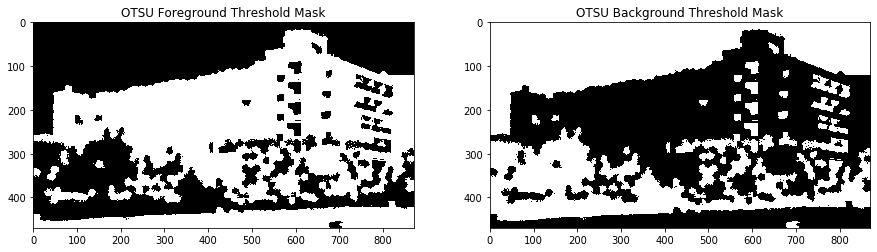

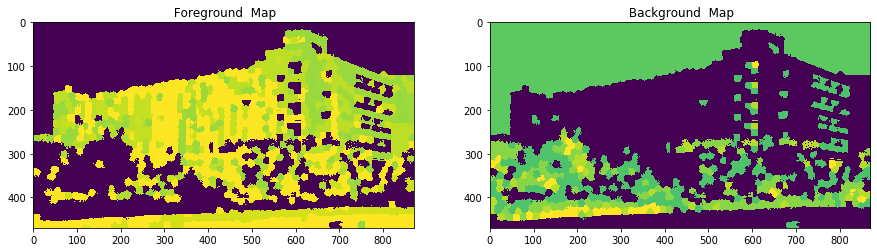

foreground mean , mu_f :  0.9340307248291779
background mean , mu_b :  0.7701175391435786
foreground  standard  deviation , sigma_f :  0.058847754803350284
background standard  deviation , sigma_b :  0.0639823212756531
z_star :  0.8535804013436417
L_s :  0.04181075069430319
For Spatial Cue 
  
OTSU Threshold : 112


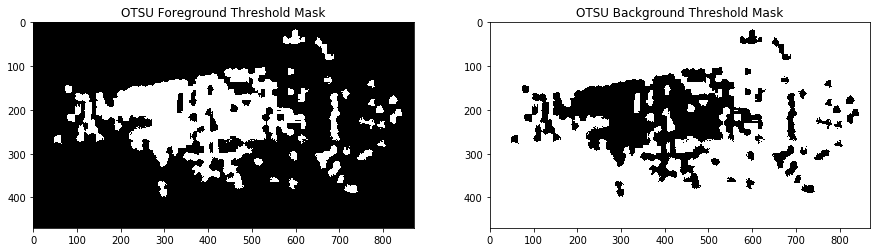

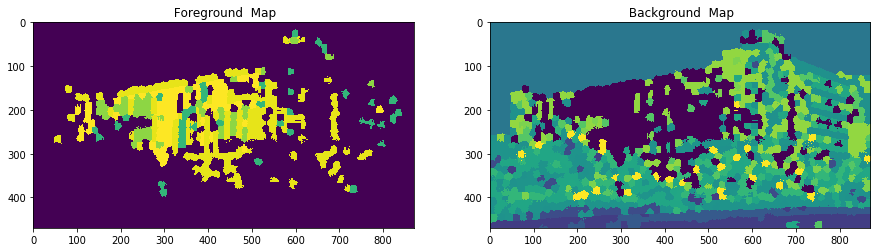

foreground mean , mu_f :  0.9123848066773336
background mean , mu_b :  0.5216685663430769
foreground  standard  deviation , sigma_f :  0.10963725717932078
background standard  deviation , sigma_b :  0.18865356131124383
z_star :  0.7411578742751466
L_s :  0.044814964264401735


In [1011]:
print('\033[1mFor Contrast Cue \n  \033[0m')
sm_1 = separation_Measure(contrast_cue_image)

print('\033[1mFor Spatial Cue \n  \033[0m')
sm_2 = separation_Measure(spatial_cue_image)

Text(0.5, 1.0, 'Final Saliency Image')

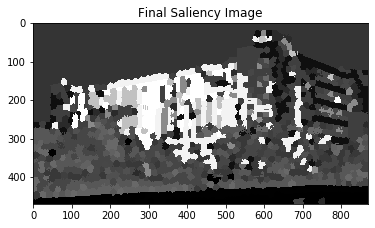

In [1012]:
final_saliency_image = np.zeros((m,n))
for i in range(m):
    for j in range(n):
        final_saliency_image[i,j] = sm_1*contrast_cues[clustered_img[i,j]] + sm_2*spatail_cues[clustered_img[i,j]]
plt.imshow(final_saliency_image, cmap = 'gray')
plt.title("Final Saliency Image")